<a href="https://colab.research.google.com/github/sammyamajumdar/my_website/blob/main/ArtworkChallengeV2_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# check GPU 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# import libraries
import os                                                
import numpy as np
import pandas as pd
import cv2                                              
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.callbacks import EarlyStopping
from keras.layers import (BatchNormalization, 
                                     Dense, 
                                     Dropout, 
                                     Flatten, 
                                     Input,
                                     RandomFlip, 
                                     RandomRotation,
                                     RandomTranslation,
                                     RandomZoom)
from keras.models import Model, Sequential

In [25]:
# load dataset with Kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adrikadatta","key":"17b478171ffcd547c458475c34b011ee"}'}

In [5]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.29G/2.29G [00:17<00:00, 177MB/s]
100% 2.29G/2.29G [00:17<00:00, 143MB/s]


In [7]:
!unzip "/content/best-artworks-of-all-time.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/resized/resized/Henri_Rousseau_61.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_62.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_63.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_64.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_65.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_66.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_67.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_68.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_69.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_7.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_70.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_8.jpg  
  inflating: /content/resized/resized/Henri_Rousseau_9.jpg  
  inflating: /content/resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: /content/resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
 

In [6]:
artists = pd.read_csv("artists.csv")
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [7]:
# grab artist names from the csv file -> number of classes ~ number of artists
artist_names = artists["name"].to_dict()
reversed_artist_names = {y : x for x,y in artist_names.items()}
print(reversed_artist_names)
n_classes = len(artist_names)
n_classes

{'Amedeo Modigliani': 0, 'Vasiliy Kandinskiy': 1, 'Diego Rivera': 2, 'Claude Monet': 3, 'Rene Magritte': 4, 'Salvador Dali': 5, 'Edouard Manet': 6, 'Andrei Rublev': 7, 'Vincent van Gogh': 8, 'Gustav Klimt': 9, 'Hieronymus Bosch': 10, 'Kazimir Malevich': 11, 'Mikhail Vrubel': 12, 'Pablo Picasso': 13, 'Peter Paul Rubens': 14, 'Pierre-Auguste Renoir': 15, 'Francisco Goya': 16, 'Frida Kahlo': 17, 'El Greco': 18, 'Albrecht Dürer': 19, 'Alfred Sisley': 20, 'Pieter Bruegel': 21, 'Marc Chagall': 22, 'Giotto di Bondone': 23, 'Sandro Botticelli': 24, 'Caravaggio': 25, 'Leonardo da Vinci': 26, 'Diego Velazquez': 27, 'Henri Matisse': 28, 'Jan van Eyck': 29, 'Edgar Degas': 30, 'Rembrandt': 31, 'Titian': 32, 'Henri de Toulouse-Lautrec': 33, 'Gustave Courbet': 34, 'Camille Pissarro': 35, 'William Turner': 36, 'Edvard Munch': 37, 'Paul Cezanne': 38, 'Eugene Delacroix': 39, 'Henri Rousseau': 40, 'Georges Seurat': 41, 'Paul Klee': 42, 'Piet Mondrian': 43, 'Joan Miro': 44, 'Andy Warhol': 45, 'Paul Gaugui

50

In [8]:
# mitigate class imbalance by using class weights
artists["class_weights"] = artists["paintings"].sum() / (artists.shape[0] * artists['paintings'])
class_weights = artists["class_weights"].to_dict()
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings,class_weights
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193,0.875233
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88,1.919545
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70,2.413143
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73,2.313973
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194,0.870722


In [9]:
print(os.listdir("resized/resized")[:10])
print(os.path.join("resized/resized", "Titian"))

['Eugene_Delacroix_7.jpg', 'Andy_Warhol_150.jpg', 'Claude_Monet_56.jpg', 'William_Turner_28.jpg', 'Salvador_Dali_103.jpg', 'Henri_de_Toulouse-Lautrec_18.jpg', 'Leonardo_da_Vinci_117.jpg', 'Joan_Miro_100.jpg', 'Vincent_van_Gogh_382.jpg', 'Edgar_Degas_178.jpg']
resized/resized/Titian


In [10]:
 # create an array of images and labels using openCV 
IMG_DIM = 224
image_files = os.listdir("resized/resized")    
image_directory = "resized/resized"        # list directory

img_list = []
label_list = []



for file in image_files:
  index = file.rfind("_")
  name = file[:index].replace("_"," ")
  if name in reversed_artist_names.keys():
    label_list.append(reversed_artist_names[name])
    img = cv2.imread(os.path.join(image_directory, file))
    img = cv2.resize(img, (IMG_DIM, IMG_DIM))
    img_list.append(img)

images = np.asarray(img_list)
labels = np.asarray(label_list)

Andy Warhol


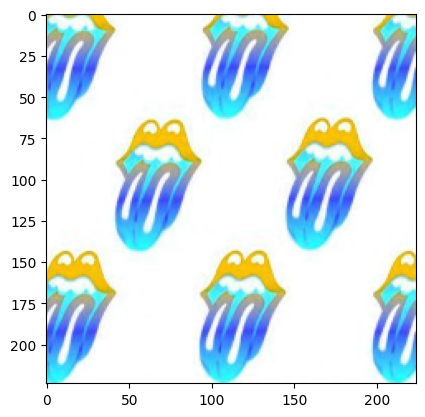

In [11]:
# sanity check
plt.imshow(images[1])
print(artist_names[labels[1]])

Rembrandt


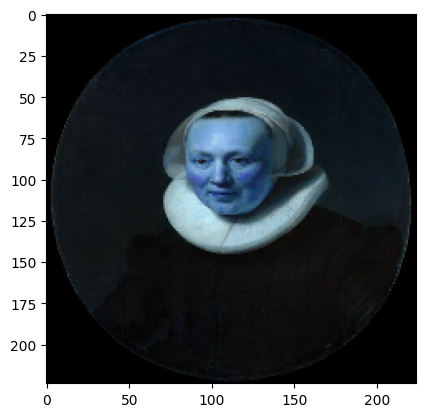

In [12]:
plt.imshow(images[16])
print(artist_names[labels[16]])

In [13]:
# split into test, train, validate
X, X_test, y, y_test = train_test_split(images, 
                                        labels, 
                                        test_size = 0.1, 
                                        random_state = 13)

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size = 1/9, 
                                                  random_state = 13)

In [14]:
# random augmentations performed on the dataset to enable better learning
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomFlip('vertical'),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])

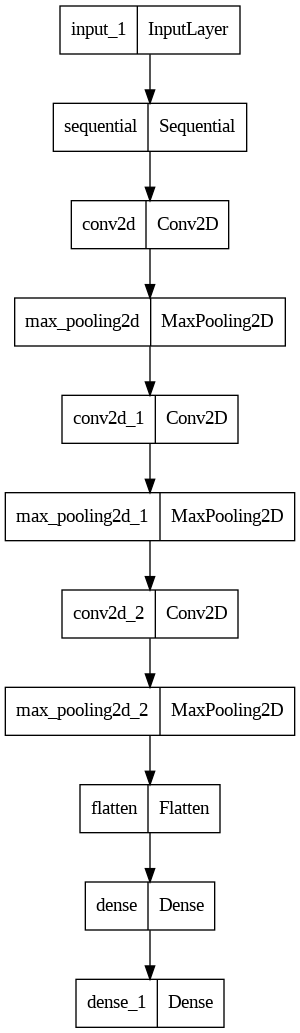

In [17]:
# Keras functional API ~ a model trained from scratch

inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processingLayer1 = data_augmentation(inputs)

ConvLayer1 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer="glorot_uniform", input_shape=(IMG_DIM, IMG_DIM, 3))(processingLayer1)
MaxPoolLayer1 = keras.layers.MaxPooling2D((2, 2))(ConvLayer1)

ConvLayer2 = keras.layers.Conv2D(128, (3, 3), activation='relu')(MaxPoolLayer1)
MaxPoolLayer2 = keras.layers.MaxPooling2D((2, 2))(ConvLayer2)

ConvLayer3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(MaxPoolLayer2)
MaxPoolLayer3 = keras.layers.MaxPooling2D((2, 2))(ConvLayer3)

flattenLayer = Flatten()(MaxPoolLayer3)
denseLayer = Dense(128, activation='relu')(flattenLayer)

outputLayer = Dense(n_classes, activation="softmax")(denseLayer)
model = Model(inputs=inputs, outputs=outputLayer, name="ArtWorkModel")

tf.keras.utils.plot_model(model, "my_first_model.png")

In [18]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train, epochs=25, 
                    class_weight = class_weights,
                    batch_size = 64,
                    validation_data=(X_val, y_val))

Epoch 1/25
101/101 [==============================] - 68s 453ms/step - loss: 10.4797 - accuracy: 0.0354 - val_loss: 3.8862 - val_accuracy: 0.0560
Epoch 2/25
101/101 [==============================] - 41s 410ms/step - loss: 3.9461 - accuracy: 0.0282 - val_loss: 3.8889 - val_accuracy: 0.0100
Epoch 3/25
101/101 [==============================] - 42s 415ms/step - loss: 3.9340 - accuracy: 0.0223 - val_loss: 3.8871 - val_accuracy: 0.0262
Epoch 4/25
101/101 [==============================] - 40s 400ms/step - loss: 3.9293 - accuracy: 0.0285 - val_loss: 3.8872 - val_accuracy: 0.0262
Epoch 5/25
101/101 [==============================] - 41s 402ms/step - loss: 3.9219 - accuracy: 0.0206 - val_loss: 3.8764 - val_accuracy: 0.0087
Epoch 6/25
101/101 [==============================] - 42s 412ms/step - loss: 3.9208 - accuracy: 0.0173 - val_loss: 3.8509 - val_accuracy: 0.0137
Epoch 7/25
101/101 [==============================] - 40s 401ms/step - loss: 3.8950 - accuracy: 0.0185 - val_loss: 3.8221 - val_a

In [26]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 10s 203ms/step - loss: 1.7311 - accuracy: 0.6663


[1.7311278581619263, 0.666251540184021]

In [16]:
### PRETRAINED MODELS - using transfer learning to utilise very deep networks trained on very large datasets ###
## VGG16
# trained without data augmentation
BASE_MODEL_TRAINABLE=False


base_model = tf.keras.applications.VGG16(include_top = False,
                   weights = "imagenet",
                   classes = n_classes, 
                   input_shape = (IMG_DIM, IMG_DIM, 3))

base_model.trainable = BASE_MODEL_TRAINABLE
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])

inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processing1 = preprocess_input(inputs)
processing1 = base_model(processing1)
outputs = prediction(processing1)
model = Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


epochs = 10
batch_size = 64


history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = epochs,
                    class_weight = class_weights,
                    batch_size = batch_size)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_2 (Sequential)   (None, 50)                13135922  
                                                                 
Total params: 27,850,610
Trainable params: 13,134,898
Non-t

In [29]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 4s 135ms/step - loss: 1.6201 - accuracy: 0.6513


[1.6200522184371948, 0.6513075828552246]

In [30]:
# VGG16 with augmentation applied

prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])

inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processing1 = data_augmentation(inputs)
processing1 = preprocess_input(inputs)
processing1 = base_model(processing1)
outputs = prediction(processing1)
model = Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 10,
                    class_weight = class_weights,
                    batch_size = 128)


model.evaluate(X_test, y_test)

Epoch 1/10
51/51 [==============================] - 58s 704ms/step - loss: 2.9226 - accuracy: 0.3822 - val_loss: 3.4519 - val_accuracy: 0.4807
Epoch 2/10
51/51 [==============================] - 33s 655ms/step - loss: 0.3416 - accuracy: 0.8569 - val_loss: 2.0880 - val_accuracy: 0.5940
Epoch 3/10
51/51 [==============================] - 33s 639ms/step - loss: 0.0823 - accuracy: 0.9556 - val_loss: 1.7129 - val_accuracy: 0.6052
Epoch 4/10
51/51 [==============================] - 32s 631ms/step - loss: 0.0268 - accuracy: 0.9869 - val_loss: 1.6635 - val_accuracy: 0.6189
Epoch 5/10
51/51 [==============================] - 33s 656ms/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 1.6156 - val_accuracy: 0.6227
Epoch 6/10
51/51 [==============================] - 32s 637ms/step - loss: 0.0067 - accuracy: 0.9991 - val_loss: 1.6356 - val_accuracy: 0.6177
Epoch 7/10
51/51 [==============================] - 32s 633ms/step - loss: 0.0046 - accuracy: 0.9997 - val_loss: 1.6519 - val_accuracy: 0.6252

[1.5421544313430786, 0.6587795615196228]

In [17]:
## ResNet 50

base_model = tf.keras.applications.ResNet50V2(include_top = False,
                   weights = "imagenet",
                   classes = n_classes, 
                   input_shape = (IMG_DIM, IMG_DIM, 3))

base_model.trainable = BASE_MODEL_TRAINABLE
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [18]:
prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])




inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processing1 = preprocess_input(inputs)
processing1 = base_model(processing1)
outputs = prediction(processing1)
model = Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 sequential_1 (Sequential)   (None, 50)                51671090  
                                                                 
Total params: 75,235,890
Trainable params: 51,670,066
Non-trainable params: 23,565,824
________________________________________

In [20]:
epochs = 10
batch_size = 64


history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = epochs,
                    class_weight = class_weights,
                    batch_size = batch_size)

Epoch 1/10
101/101 [==============================] - 29s 250ms/step - loss: 4.2493 - accuracy: 0.0744 - val_loss: 4.7646 - val_accuracy: 0.0909
Epoch 2/10
101/101 [==============================] - 21s 209ms/step - loss: 3.3939 - accuracy: 0.1461 - val_loss: 4.1274 - val_accuracy: 0.0785
Epoch 3/10
101/101 [==============================] - 21s 204ms/step - loss: 2.7349 - accuracy: 0.2436 - val_loss: 3.9307 - val_accuracy: 0.1046
Epoch 4/10
101/101 [==============================] - 20s 201ms/step - loss: 2.1763 - accuracy: 0.3404 - val_loss: 4.2167 - val_accuracy: 0.0922
Epoch 5/10
101/101 [==============================] - 20s 198ms/step - loss: 1.6420 - accuracy: 0.4502 - val_loss: 3.7525 - val_accuracy: 0.1694
Epoch 6/10
101/101 [==============================] - 21s 205ms/step - loss: 1.2290 - accuracy: 0.5435 - val_loss: 4.7606 - val_accuracy: 0.1133
Epoch 7/10
101/101 [==============================] - 21s 203ms/step - loss: 1.0725 - accuracy: 0.6046 - val_loss: 4.4489 - val_ac

In [21]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 4s 115ms/step - loss: 4.2737 - accuracy: 0.2154


[4.273731708526611, 0.21544209122657776]

In [22]:
# ConvNeXt XLarge model
base_model = tf.keras.applications.ConvNeXtXLarge(
    model_name="convnext_xlarge",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

base_model.trainable = BASE_MODEL_TRAINABLE
base_model.summary()

1401457568/1401457568 [==============================] - 11s 0us/step
Model: "convnext_xlarge"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_xlarge_prestem_normal  (None, 224, 224, 3)  0          ['input_5[0][0]']                
 ization (Normalization)                                                                          
                                                                                                  
 convnext_xlarge_stem (Sequenti  (None, 56, 56, 256)  13056      ['convnext_xlarge_prestem_normali
 al)          

In [23]:
prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])




inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processing1 = preprocess_input(inputs)
processing1 = base_model(processing1)
outputs = prediction(processing1)
model = Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 10,
                    class_weight = class_weights,
                    batch_size = 64)

Epoch 1/10
101/101 [==============================] - 468s 4s/step - loss: 2.6855 - accuracy: 0.3601 - val_loss: 2.4573 - val_accuracy: 0.4458
Epoch 2/10
101/101 [==============================] - 388s 4s/step - loss: 1.3622 - accuracy: 0.5814 - val_loss: 1.9495 - val_accuracy: 0.5268
Epoch 3/10
101/101 [==============================] - 426s 4s/step - loss: 1.0538 - accuracy: 0.6424 - val_loss: 1.9122 - val_accuracy: 0.5629
Epoch 4/10
101/101 [==============================] - 427s 4s/step - loss: 0.8230 - accuracy: 0.7007 - val_loss: 2.0706 - val_accuracy: 0.5467
Epoch 5/10
101/101 [==============================] - 388s 4s/step - loss: 0.6668 - accuracy: 0.7326 - val_loss: 1.8786 - val_accuracy: 0.5903
Epoch 6/10
101/101 [==============================] - 427s 4s/step - loss: 0.6027 - accuracy: 0.7602 - val_loss: 1.9162 - val_accuracy: 0.5866
Epoch 7/10
101/101 [==============================] - 427s 4s/step - loss: 0.5193 - accuracy: 0.7804 - val_loss: 1.8148 - val_accuracy: 0.6264

In [24]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 53s 2s/step - loss: 2.5460 - accuracy: 0.5741


[2.5459582805633545, 0.5740971565246582]